In [104]:
import random
import math
import copy
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
random.seed(123)
# Funkcja zwracająca koszt dla danego rozwiązania
def oblicz_koszt(rozwiazanie, odleglosc):
    # Zwracamy sumę odległości między kolejnymi miastami w rozwiązaniu
    koszt = 0
    for i in range(len(rozwiazanie) - 1):
        koszt += odleglosc[rozwiazanie[i]][rozwiazanie[i + 1]]
    # Dodajemy koszt drogi powrotnej do pierwszego miasta
    koszt += odleglosc[rozwiazanie[-1]][rozwiazanie[0]]
    return koszt

# Funkcja generująca słownik funkcji określającej
# Prawdopodobieństwo przyjęcia kandydata
# Słownik ma postać {funkcja: lista_parametrów}
def metropolis_probability(delta_e, temperature, prob_parameter=None):
    return min(1, math.exp(-delta_e / temperature))

def boltzmann_probability(delta_e, temperature, prob_parameter=None):
        return math.exp(-delta_e / temperature)

def gaussian_probability(delta_e, temperature, prob_parameter=3): # z sigmami chyba można mocno kombinować
    return math.exp(-(delta_e ** 2) / (2 * (prob_parameter ** 2) * temperature))

def exponential_decrease_probability(delta_e, temperature, prob_parameter=1): #alpha
        return math.exp(-prob_parameter * delta_e / temperature)


def power_law_probability(delta_e, temperature, prob_parameter): # decay_factor raczej jakiś taki okolo 2
        return 1 / ((delta_e + 1) ** prob_parameter * temperature)
def prob_functions_dict():



    

    
    # def sigmoid_probability(delta_e, temperature, prob_parameter):
    #     return 1 / (1 + math.exp(-prob_parameter * delta_e / temperature)) #sigmoid

   

    

    decay_factors = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6]

    sigma_factors = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3]

    alpha_factors = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    # sigmoid_parameters = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 3, 4]

    return {metropolis_probability: [None], boltzmann_probability: [None],
            exponential_decrease_probability: alpha_factors,
            gaussian_probability: sigma_factors, power_law_probability: decay_factors}

# Funkcja generująca słownik funkcji określającej
# Zmianę temperatury wraz z działaniem algorytmu
# Słownik ma postać {funkcja: lista_parametrów}
def t_decrease_functions_dict():



    # def exponential_cooling(T_init, T, iteration, cool_parameter):  # około 0.05
    #     return T_init * math.exp(-cool_parameter * iteration)

    linear_parameters = [0.9999, 0.99999, 0.999999, 0.9999999]

    #exp_parameters = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

    return {
        #exponential_cooling: exp_parameters,
        linear_decrease: linear_parameters
            }

# Funkcja czytająca format .atsp
# Zwraca macierz sąsiedztwa
def read_atsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

        # Extract the dimension of the problem
        for line in lines:
            if line.startswith('DIMENSION'):
                n = int(line.strip().split()[1])
                break

        # Extract the matrix
        matrix = []
        row = []
        start_reading = False
        for line in lines:
            if line.startswith('EDGE_WEIGHT_SECTION'):
                start_reading = True
                continue
            if start_reading:
                lista_liczb = list(map(int, line.strip().split()))
                for i in lista_liczb:
                    row.append(i)
                    if len(row) == n:
                        matrix.append(row)
                        row = []
                if len(matrix) == n:
                    break
        for i in range(len(matrix)):
            matrix[i][i]= 1000000

    return matrix

def simulated_annealing(T_init, T_function, cool_parameter,
                        Prob_function, prob_parameter,
                        break_point, file_name):
    

    odleglosc = read_atsp_file(file_name)
    miasta = [i for i in range(len(odleglosc))]

    liczba_iteracji = 1000000  # liczba iteracji

    # Losujemy początkowe rozwiązanie
    S = random.sample(range(len(miasta)), len(miasta))

    # Pętla główna algorytmu
    C1, C2 = 0, 0
    T = T_init

    global_min = float('inf')
    global_min_path = []

    list_of_costs=[i for i in range(100)]

    for i in range(liczba_iteracji):

        # Losujemy dwa miasta i zamieniamy je miejscami
        S_p = S.copy()
        a = random.randint(0, len(S_p) - 1)
        b = random.randint(0, len(S_p) - 1)
        S_p[a], S_p[b] = S_p[b], S_p[a]

        # Obliczamy koszty dla obu rozwiązań
        C1 = oblicz_koszt(S, odleglosc)
        C2 = oblicz_koszt(S_p, odleglosc)

        # Sprawdzamy czy akceptujemy nowe rozwiązanie
        if C2 < C1:
            S = S_p
        else:
            delta_e = abs(C1-C2)
            p = Prob_function(delta_e, T, prob_parameter)
            if random.random() < p:
                S = S_p

        if i % 10000 == 0:
            print(min(C1, C2))
            #tu zmienione, zeby tworzylo liste kosztow
            list_of_costs[i//10000]=global_min


            print(T)

        # Zmniejszamy temperaturę
        T = T_function(T_init, T, i, cool_parameter)
        if T < break_point:
            break
        if oblicz_koszt(S, odleglosc) < global_min:
            global_min_path = [miasta[i] for i in S]
            global_min = oblicz_koszt(S, odleglosc)

    # Zwracamy najlepsze znalezione rozwiązanie
    najlepsze_rozwiazanie = [miasta[i] for i in S]
    end = time.time()

    return global_min_path, global_min,  list_of_costs
    # Sciezka, koszt, lista kosztów- NOWE

def linear_decrease(Top_T, T, iteration, cool_parameter):
    return T * cool_parameter

def main():

    prob_dict = []
    temp_dict = t_decrease_functions_dict()

    starting_temperatures = [50000]  # Lista temperatur początkowych

    file_names = ['data/ftv170.atsp']  # Lista nazw plików

    min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

    df = pd.DataFrame(columns=['file_name', 'prob_function', 'prob_parameter', 'temp_function',
                               'cool_parameter', 'T_init', 'function_result', 'time', 'path'])

    

In [ ]:
#PARAMETR CHLODZENIA
dict={}
starting_temperatures = [50000] 
file = 'data/ftv33.atsp'  

min_temperature = 0.1 # Minimalna temperatura, określa potencjalny czas trwania algorytmu

linear_parameters = [0.999, 0.9999, 0.99999]
dict= {k: [] for k in linear_parameters}
for parametr in linear_parameters:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                            cool_parameter=parametr,
                                                            Prob_function=gaussian_probability, prob_parameter=3,
                                                            break_point=min_temperature, file_name=file)
        dict[parametr].append(function_result)

print(dict)

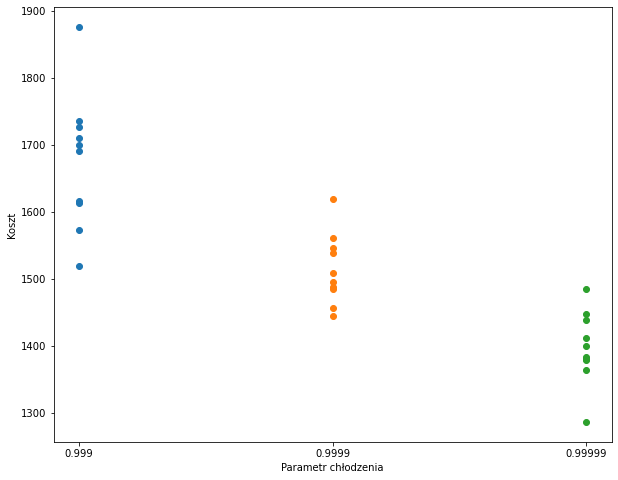

In [106]:
#wykres do parametrów chłodzenia
linear_parameters = [0.999, 0.9999, 0.99999]
plt.figure(figsize=(10,8))
plt.xlabel("Parametr chłodzenia")
plt.ylabel("Koszt")
for param in linear_parameters:
    
    plt.scatter([str(param)]*len(dict[param]), dict[param], label=param)


In [ ]:
#TEMPERATURA CHŁODZENIA
dict={}
starting_temperatures = [50000, 30000, 15000, 5000]  

dict= {k: [] for k in starting_temperatures}
for temp in starting_temperatures:
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=temp, T_function=linear_decrease,
                                                            cool_parameter=0.99999,
                                                            Prob_function=metropolis_probability, prob_parameter=None,
                                                            break_point=min_temperature, file_name=file)
        dict[temp].append(function_result)


print(dict)


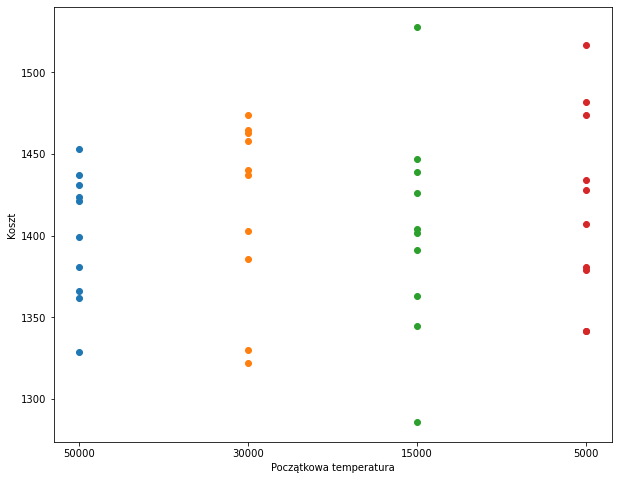

In [108]:
#wykres dla poczatkowych temperatur

plt.figure(figsize=(10,8))
plt.xlabel("Początkowa temperatura")
plt.ylabel("Koszt")
for temp in starting_temperatures:
    plt.scatter([str(temp)]*len(dict[temp]), dict[temp], label=temp)


In [ ]:
dict={}


parametry=[None, None,1, 3, 2 ]

prob_functions=[metropolis_probability, exponential_decrease_probability, gaussian_probability,power_law_probability]

dict= {k: [] for k in prob_functions}
i=0
for fun in prob_functions:
    prob_parameter=parametry[i]
    for _ in range(10):

        path, function_result, time1 = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                            cool_parameter=0.99999,
                                                            Prob_function=fun, prob_parameter=parametry[i],
                                                            break_point=min_temperature, file_name=file)
        dict[fun].append(function_result)
    i+=1


#print(dict)

([<matplotlib.axis.XTick at 0x7ff66b1259c0>,
 [Text(0.0, 0, 'metropolis'),
  Text(1.0, 0, 'exponential decrease'),
  Text(2.0, 0, 'gaussian'),
  Text(3.0, 0, 'power law')])

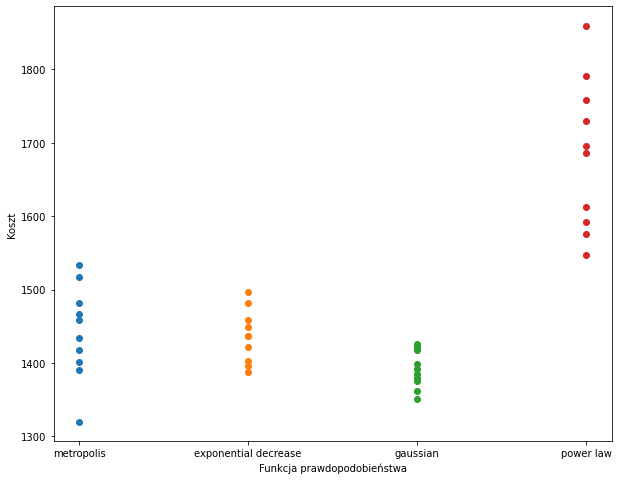

In [137]:
plt.figure(figsize=(10,8))
plt.xlabel("Funkcja prawdopodobieństwa")
plt.ylabel("Koszt")
prob_functions=[metropolis_probability, exponential_decrease_probability, gaussian_probability,power_law_probability]
dict= {metropolis_probability: [1434, 1533, 1482, 1466, 1517, 1320, 1401, 1459, 1390, 1417],  exponential_decrease_probability: [1387, 1459, 1436, 1496, 1402, 1422, 1437, 1449, 1482, 1396],gaussian_probability: [1362, 1385, 1375, 1392, 1421, 1351, 1417, 1379, 1426, 1399],power_law_probability: [1695, 1547, 1686, 1791, 1592, 1576, 1730, 1859, 1613, 1759]}
prob_functions1=['metropolis_probability', 'exponential_decrease_probability', 'gaussian_probability','power_law_probability']

for fun in prob_functions:
    plt.scatter([str(fun.__name__)]*len(dict[fun]), dict[fun], label=fun)

plt.xticks(prob_functions1, labels=('metropolis', 'exponential decrease', 'gaussian', 'power law'))



In [ ]:
#wykres zaleznosci kosztu od iteracji
dict={}
dict= {k: [] for k in range(10)}
for i in range(10):
    path, function_result, list_of_costs = simulated_annealing(T_init=30000, T_function=linear_decrease,
                                                        cool_parameter=0.99999,
                                                        Prob_function=metropolis_probability, prob_parameter=None,
                                                        break_point=0.1, file_name=file)
    dict[i].append(list_of_costs)
x=list(range(0,1000000,10000))



In [ ]:
mean_cost=[0]*100
suma=0
for i in range(len(list_of_costs)):
    for k in range(10):
        suma+= dict[k][0][i]
    mean_cost[i]=suma/10
    suma=0

mean_cost

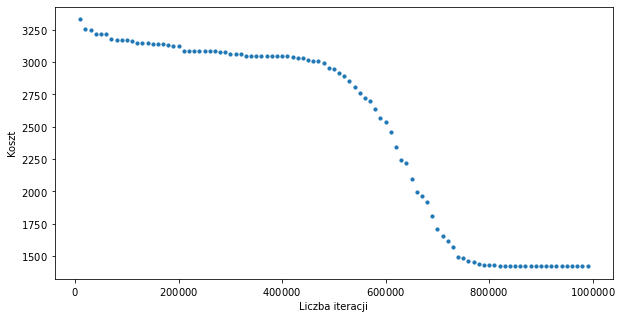

In [115]:

plt.figure(figsize=(10,5))
plt.scatter(x,mean_cost, s=10)
plt.xlabel("Liczba iteracji")
plt.ylabel("Koszt")
plt.ticklabel_format(style='plain', axis='both')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.gca().get_xaxis().set_major_formatter(formatter)
plt.gca().get_yaxis().set_major_formatter(formatter)


